# Rede CNN - Modelo 2

## Dataset Respiratory_Sound_Database_Pneumo_Healthy_Only - Dataset 1 - trim8

In [1]:
from datetime import datetime
from os import listdir
from os.path import isfile, join

import os
import librosa
import librosa.display
import glob

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Necessário na minha máquina. Estava ocorrendo um erro devido à GPU e esse código resolveu.
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [35]:
GROUP_TRAIN = 'trim8'
GROUP_TEST = 'trim8'
DATASET = 'dataset_1'
DURATION = 8
SIZE = 345
CSV_TRAIN = 'train1.csv'
CSV_TEST = 'test1.csv'
MODEL_NAME = f'CNN2_{DATASET}_{GROUP_TRAIN}'

In [36]:
train_file_paths = glob.glob(f'../datasets/{DATASET}/{GROUP_TRAIN}/train/**/*.wav', recursive=True)
train_file_names = [os.path.splitext(os.path.basename(p))[0] for p in train_file_paths]

test_file_paths = glob.glob(f'../datasets/{DATASET}/{GROUP_TEST}/test/**/*.wav', recursive=True)
test_file_names = [os.path.splitext(os.path.basename(p))[0] for p in test_file_paths]

In [37]:
train_p_id_in_file = [] # patient IDs corresponding to each file
test_p_id_in_file = [] # patient IDs corresponding to each file
for name in train_file_names:
    train_p_id_in_file.append(int(name[:3]))

for name in test_file_names:
    test_p_id_in_file.append(int(name[:3]))

train_p_id_in_file = np.array(train_p_id_in_file)
test_p_id_in_file = np.array(test_p_id_in_file) 

In [38]:
max_pad_len = SIZE

os.makedirs("features/", exist_ok=True)

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
    feature = os.path.splitext(os.path.basename(file_name))[0] + ".npy"
#     if (os.path.isfile(os.path.join("./Respiratory_Sound_Database/features/", feature))):
#         return np.load(os.path.join("./Respiratory_Sound_Database/features/", feature))
    
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=DURATION) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print(e)
        return None 
    np.save(os.path.join("./features/", feature), mfccs)
    return mfccs

In [39]:
#filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [40]:
train_p_diag = pd.read_csv(f"../Respiratory_Sound_Database/Respiratory_Sound_Database_Pneumo_Healthy_Only/{CSV_TRAIN}", header=None) # patient diagnosis file
test_p_diag = pd.read_csv(f"../Respiratory_Sound_Database/Respiratory_Sound_Database_Pneumo_Healthy_Only/{CSV_TEST}", header=None) # patient diagnosis file
train_p_diag.head(5)

,0,1
0,102,Healthy
1,121,Healthy
2,123,Healthy
3,125,Healthy
4,126,Healthy


In [41]:
train_labels = np.array([train_p_diag[train_p_diag[0] == x][1].values[0] for x in train_p_id_in_file]) 
test_labels = np.array([test_p_diag[test_p_diag[0] == x][1].values[0] for x in test_p_id_in_file]) 

In [42]:
train_features = [] 
test_features = []

for file_name in train_file_paths:
    data = extract_features(file_name)
    train_features.append(data)

for file_name in test_file_paths:
    data = extract_features(file_name)
    test_features.append(data)

print('Finished feature extraction from ', (len(train_features)+len(train_features)), ' files')
train_features = np.array(train_features)
test_features = np.array(test_features)

Finished feature extraction from  244  files


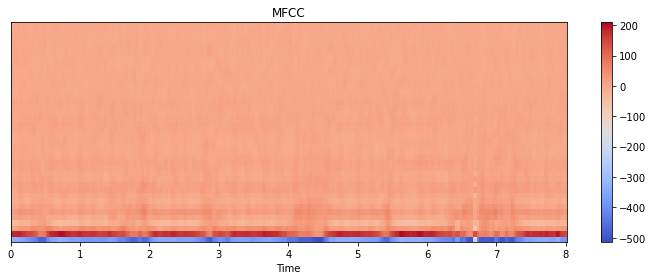

In [43]:
# plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(train_features[7], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [44]:
np.unique(train_labels)

array(['Healthy', 'Pneumonia'], dtype='<U9')

In [45]:
unique_elements, counts_elements = np.unique(train_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

unique_elements_test, counts_elements_test = np.unique(test_labels, return_counts=True)
print(np.asarray((unique_elements_test, counts_elements_test)))

[['Healthy' 'Pneumonia']
 ['64' '58']]
[['Healthy' 'Pneumonia']
 ['6' '16']]


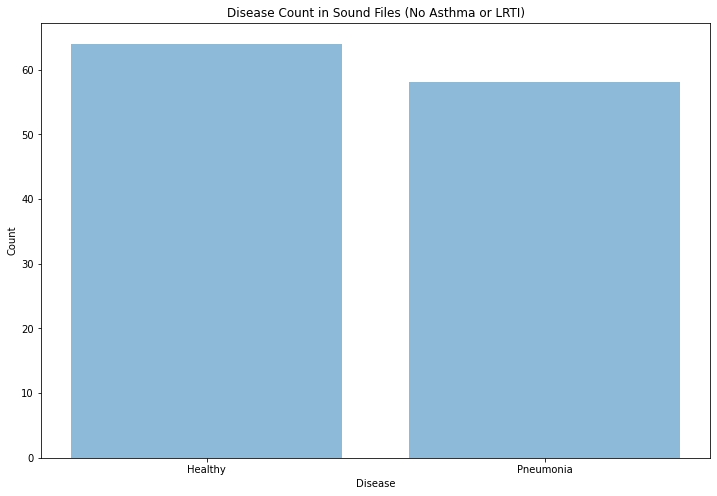

In [46]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.show()

__Balanceando dados__

In [47]:
def balance_data(X, labels):
    """Balances data duplicating some instances of the minority classes"""
    balX = None
    baly = None
    unique, counts = np.unique(labels, return_counts=True)
    max_inst = max(counts)
    # For every class duplicate the necessary amount
    for label in unique:
        data_of_label = []
        for x, y in zip(X, labels):
            if y == label:
                data_of_label.append(x)
        data_of_label = np.asarray(data_of_label)
        extra = data_of_label[np.random.choice(data_of_label.shape[0],
                                               max_inst,
                                               replace=True), :]
        if balX is not None:
            balX = np.stack((balX, extra), axis = 0) 
            baly = np.stack((baly, np.asarray([label for i in range(len(extra))])))
        else:
            balX = extra
            baly = np.asarray([label for i in range(len(extra))])
    balX = np.concatenate(balX)
    baly = np.concatenate(baly)
    return balX, baly

In [48]:
train_features, train_labels = balance_data(train_features, train_labels)
test_features, test_labels = balance_data(test_features, test_labels)

In [49]:
unique_elements, counts_elements = np.unique(train_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

unique_elements_test, counts_elements_test = np.unique(test_labels, return_counts=True)
print(np.asarray((unique_elements_test, counts_elements_test)))

[['Healthy' 'Pneumonia']
 ['64' '64']]
[['Healthy' 'Pneumonia']
 ['16' '16']]


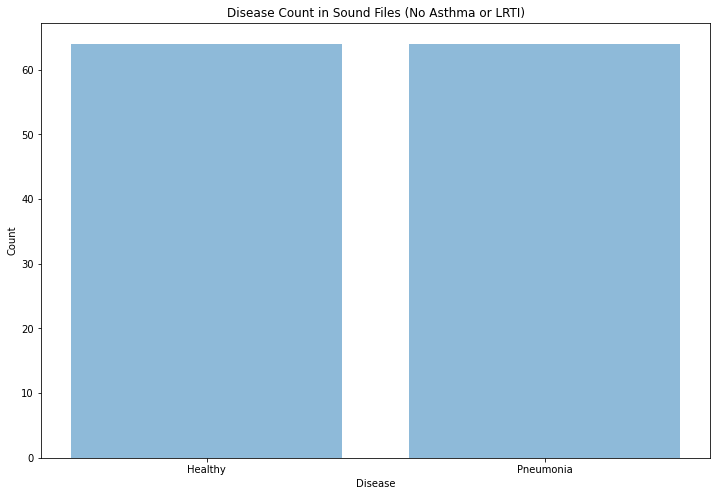

In [50]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.show()

In [51]:
# One-hot encode labels
le = LabelEncoder()
le.fit(train_labels)
train_labels_cat = to_categorical(le.transform(train_labels)) 
test_labels_cat = to_categorical(le.transform(test_labels)) 

In [52]:
train_features.shape

(128, 40, 345)

In [53]:
train_features = np.reshape(train_features, (*train_features.shape,1)) 
print(train_features.shape, train_labels_cat.shape)
test_features = np.reshape(test_features, (*test_features.shape,1)) 
print(test_features.shape, test_labels_cat.shape)

(128, 40, 345, 1) (128, 2)
(32, 40, 345, 1) (32, 2)


In [54]:
x_test, y_test = test_features, test_labels_cat
x_train, y_train = train_features, train_labels_cat

**CNN model architecture**

In [55]:
num_labels = train_labels_cat.shape[1]

num_rows = 40
num_columns = SIZE
num_channels = 1

filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

model.add(Conv2D(filters=16, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

model.add(Conv2D(filters=8, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

model.add(Conv2D(filters=4, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [56]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [57]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 344, 32)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 172, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 172, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 171, 16)       2064      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 85, 16)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 85, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 84, 8)          5

**Training**

Here we will train the model. If we have a trained model, we can load it instead from the next cell.

In [58]:
# train model
num_epochs = 500
num_batch_size = 10

os.makedirs('models', exist_ok=True)
callbacks = [
    ModelCheckpoint(
        filepath='models/' + MODEL_NAME + '_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 128 samples, validate on 32 samples
Epoch 1/500
 70/128 [===============>..............] - ETA: 0s - loss: 6.1265 - accuracy: 0.5429
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to models/CNN2_dataset_1_trim8_01.h5
128/128 [==============================] - 1s 7ms/sample - loss: 4.7907 - accuracy: 0.5547 - val_loss: 1.6265 - val_accuracy: 0.5000
Epoch 2/500
 70/128 [===============>..............] - ETA: 0s - loss: 2.8349 - accuracy: 0.5429
Epoch 00002: val_accuracy did not improve from 0.50000
128/128 [==============================] - 0s 977us/sample - loss: 2.9152 - accuracy: 0.5469 - val_loss: 0.9160 - val_accuracy: 0.5000
Epoch 3/500
 80/128 [=================>............] - ETA: 0s - loss: 2.1603 - accuracy: 0.4250
Epoch 00003: val_accuracy did not improve from 0.50000
128/128 [==============================] - 0s 1ms/sample - loss: 2.1011 - accuracy: 0.4609 - val_loss: 0.8921 - val_accuracy: 0.5000
Epoch 4/500
110/128 [========================>

**Plot accuracies and losses**

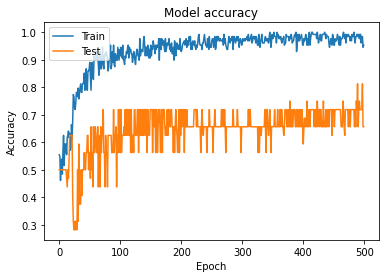

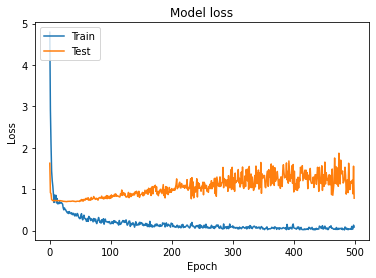

In [59]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Teste

In [60]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
train_acc = score[1]
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
test_acc = score[1]
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.96875
Testing Accuracy:  0.65625


In [61]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=2 # number of classes

In [62]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [63]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']
c_names = ['Healthy', 'Pneumonia']

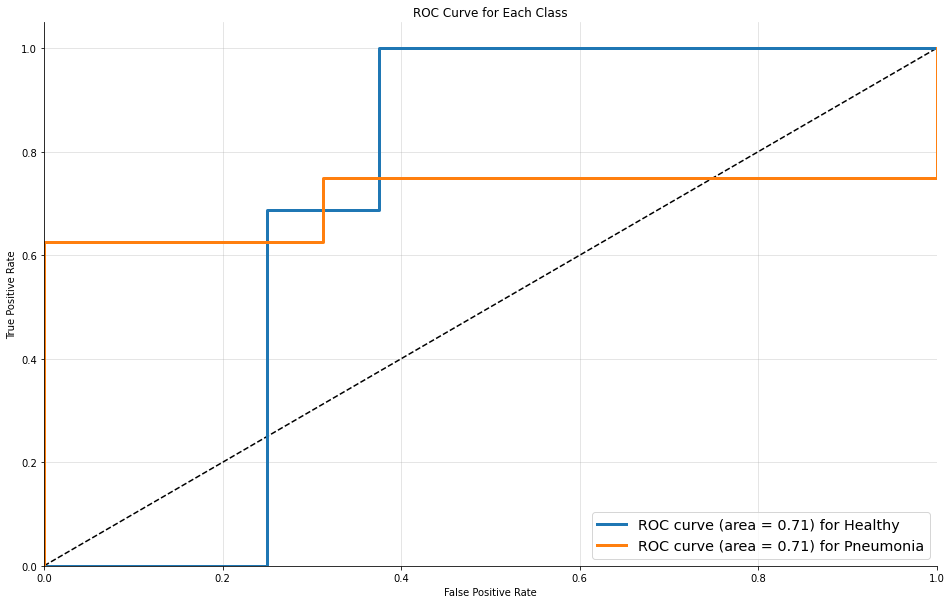

In [64]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [65]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

              precision    recall  f1-score   support

     Healthy       0.65      0.69      0.67        16
   Pneumonia       0.67      0.62      0.65        16

    accuracy                           0.66        32
   macro avg       0.66      0.66      0.66        32
weighted avg       0.66      0.66      0.66        32



In [66]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[11  5]
 [ 6 10]]


In [67]:
import itertools
def plot_confusion_matrix(cm, unique_labels, show=True, output=None,
                          title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks() + 1).astype(str))
    plt.yticks(tick_marks)

    ax.set_xticklabels(unique_labels)
    ax.set_yticklabels(unique_labels)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if show:
        plt.show()
    if output is not None:
        plt.savefig(output)
    plt.close()
    return output


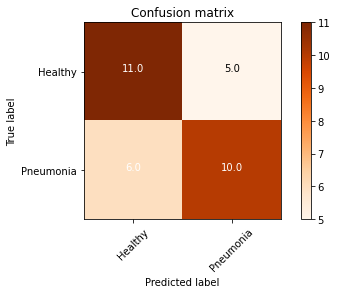

In [68]:
plot_confusion_matrix(confusion_matrix(y_testclass, classpreds), unique_labels=["Healthy", "Pneumonia"])

__Write CSV__

In [69]:
with open('report.csv', 'a') as report:
    report.write(f'{MODEL_NAME},{DATASET},{GROUP_TRAIN},{DURATION},{train_acc},{test_acc}\n')